In [846]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import talib 
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL', 'SPY']#FAANG portfolio with SPY for market proxy

In [847]:
class DataPreprocessor:
    def __init__(self, tickers,):
        self.tickers = tickers
        self.data = None
        
    def run_pipeline(self, start_date='2000-01-01', end_date='2025-12-31'):
        self._download_data(start_date, end_date)
        self._clean_data()
        return self.data
    
    def _download_data(self, start_date, end_date):
        all_data = []
        
        for ticker in self.tickers:
            
            # Download with adjusted close prices and make column names lower
            df = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
            
            if isinstance(df.columns, pd.MultiIndex): 
                df.columns = [col[0].lower() for col in df.columns]
            else:
                df.columns = [col.lower() for col in df.columns]
            
            df.index.names = [name.lower() if name else 'date' for name in df.index.names]
            
            df = df[['open', 'high', 'low', 'close', 'volume']] # Keep only essential columns
            
            df['ticker'] = ticker # Add ticker column and set multi-index, organize data
            df = df.reset_index()
            df.set_index(['ticker', 'date'], inplace=True)
            
            all_data.append(df)
        
        self.data = pd.concat(all_data, axis=0).sort_index()

    def _clean_data(self):
        all_dates = {}
        for ticker in self.data.index.get_level_values('ticker').unique():
            ticker_data = self.data.xs(ticker, level='ticker')
            all_dates[ticker] = set(ticker_data.index)
        
        # Find common dates across all tickers
        common_dates = set.intersection(*all_dates.values())
        common_dates = sorted(list(common_dates))
        # 2. Filter each ticker to only common dates
        aligned_data = []
        for ticker in self.data.index.get_level_values('ticker').unique():
            ticker_data = self.data.xs(ticker, level='ticker')
            ticker_data = ticker_data[ticker_data.index.isin(common_dates)]
            ticker_data['ticker'] = ticker
            ticker_data = ticker_data.reset_index()
            ticker_data.set_index(['ticker', 'date'], inplace=True)
            aligned_data.append(ticker_data)
        
        self.data = pd.concat(aligned_data, axis=0).sort_index()
        
        # 3. Fill any remaining small gaps within common dates
        self.data = self.data.groupby(level='ticker', group_keys=False).apply(lambda x: x.ffill().bfill())
        
        # 4. Final check - drop any NaN that might remain
        initial_shape = self.data.shape[0]
        self.data = self.data.dropna()
        if self.data.shape[0] < initial_shape:
            print(f"Dropped {initial_shape - self.data.shape[0]} rows with NaN values")
dp = DataPreprocessor(tickers)
data = dp.run_pipeline(start_date='2000-01-01', end_date='2024-12-31')


In [848]:
class FeatureEngineer:
    def __init__(self, data):
        self.data = data.copy()
        self.finished_features = []
        
    def run_pipeline(self):
        self.core_price_features()
        self.math_rule_features()
        self.momentum_features()
        self.volatility_features()
        self.volume_features()
        self.lagged_features()
        self.target_variable()
        return self.data
    
    def _apply_by_ticker(self, func):
        result = self.data.groupby(level='ticker', group_keys=False).apply(func)
        # Ensure MultiIndex is preserved with correct names
        if result.index.nlevels == 2:
            result.index = result.index.set_names(['ticker', 'date'])
        elif result.index.nlevels == 1:
            # groupby collapsed the index — rebuild it from columns
            if 'ticker' in result.columns and 'date' in result.columns:
                result = result.set_index(['ticker', 'date'])
            elif 'ticker' in result.columns:
                result = result.reset_index().set_index(['ticker', 'date'])
            else:
                # Reconstruct from original data's index
                result.index = self.data.index
        elif result.index.nlevels > 2:
            # Extra level added by groupby — drop the outermost
            result = result.droplevel(0)
            result.index = result.index.set_names(['ticker', 'date'])
        return result
    
    def core_price_features(self):
        def calc(df):
            close, high, low, open_ = df['close'], df['high'], df['low'], df['open']
            
            # Returns
            df['log_return'] = np.log(close / close.shift(1))
            df['overnight_return'] = np.log(open_ / close.shift(1))
            df['intraday_return'] = np.log(close / open_)
            # Volatility
            df['volatility_20d'] = df['log_return'].rolling(20).std() * np.sqrt(252)
            df['atr_14'] = talib.ATR(high, low, close, timeperiod=14)
            # SMAs
            sma10 = talib.SMA(close, timeperiod=10)
            sma20 = talib.SMA(close, timeperiod=20)
            sma50 = talib.SMA(close, timeperiod=50)
            #ratios
            df['price_sma20_ratio'] = close / sma20
            df['price_sma50_ratio'] = close / sma50
            df['sma10_sma20_ratio'] = sma10 / sma20
            return df
        
        self.data = self._apply_by_ticker(calc)
        self.finished_features += ['log_return', 'overnight_return', 'intraday_return', 'volatility_20d', 'atr_14', 'price_sma20_ratio', 'price_sma50_ratio', 'sma10_sma20_ratio']
    
    def math_rule_features(self):
        def calc(df):
            close, high, low, volume = df['close'], df['high'], df['low'], df['volume']
            
            # SMAs
            sma10 = talib.SMA(close, timeperiod=10)
            sma20 = talib.SMA(close, timeperiod=20)
            sma50 = talib.SMA(close, timeperiod=50)
            sma200 = talib.SMA(close, timeperiod=200)
            
            # Trends
            df['golden_cross'] = (sma50 > sma200).astype(int)
            df['short_uptrend'] = (sma10 > sma20).astype(int)
            df['price_above_sma20'] = (close > sma20).astype(int)
            df['price_above_sma50'] = (close > sma50).astype(int)
            
            # Momentum
            rsi = talib.RSI(close, timeperiod=14)
            macd, signal, _ = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
            stoch_k, _ = talib.STOCH(high, low, close, fastk_period=14, slowk_period=3, slowd_period=3)
            roc = talib.ROC(close, timeperiod=10)
            df['rsi_oversold'] = (rsi < 30).astype(int)
            df['rsi_overbought'] = (rsi > 70).astype(int)
            df['macd_bullish'] = (macd > signal).astype(int)
            df['roc_positive'] = (roc > 0).astype(int)
            df['stoch_oversold'] = (stoch_k < 20).astype(int)
            
            # Volatility/Reversion 
            upper, _, lower = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2)
            bb_pos = (close - lower) / (upper - lower)
            vol_20d = df['log_return'].rolling(20).std() * np.sqrt(252)
            vol_75pct = vol_20d.rolling(window=252, min_periods=50).quantile(0.75)  # FIXED: Use rolling instead of expanding
            df['bb_oversold'] = (bb_pos < 0.2).astype(int)
            df['bb_overbought'] = (bb_pos > 0.8).astype(int)
            df['high_volatility'] = (vol_20d > vol_75pct).astype(int)
            
            # Volume 
            vol_sma20 = talib.SMA(volume, timeperiod=20)
            vol_ratio = volume / vol_sma20
            price_up = close > close.shift(1)
            price_down = close < close.shift(1)
            df['volume_spike'] = (vol_ratio > 1.5).astype(int)
            df['volume_confirmation'] = (price_up & (vol_ratio > 1)).astype(int)
            df['volume_divergence'] = (price_down & (vol_ratio > 1)).astype(int)
            return df
        
        self.data = self._apply_by_ticker(calc)
        self.finished_features += ['golden_cross', 'short_uptrend', 'price_above_sma20', 'price_above_sma50','rsi_oversold', 'rsi_overbought', 'macd_bullish', 'roc_positive', 'stoch_oversold','bb_oversold', 'bb_overbought', 'high_volatility','volume_spike', 'volume_confirmation', 'volume_divergence']
    
    def momentum_features(self):
        def calc(df):
            close, high, low = df['close'], df['high'], df['low']
            
            df['rsi_14'] = talib.RSI(close, timeperiod=14)
            macd, signal, hist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
            df['macd_histogram'] = hist
            df['stoch_k'], _ = talib.STOCH(high, low, close, fastk_period=14, slowk_period=3, slowd_period=3)
            df['williams_r'] = talib.WILLR(high, low, close, timeperiod=14)
            df['roc_10'] = talib.ROC(close, timeperiod=10)
            return df
        
        self.data = self._apply_by_ticker(calc)
        self.finished_features += ['rsi_14', 'macd_histogram', 'stoch_k', 'williams_r', 'roc_10']
    
    def volatility_features(self):
        def calc(df):
            close, high, low = df['close'], df['high'], df['low']
            
            upper, middle, lower = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2)
            df['bb_position'] = (close - lower) / (upper - lower)
            df['bb_width'] = (upper - lower) / middle
            df['parkinson_vol'] = np.sqrt((1 / (4 * np.log(2))) * (np.log(high / low) ** 2)).rolling(20).mean()
            return df
        
        self.data = self._apply_by_ticker(calc)
        self.finished_features += ['bb_position', 'bb_width', 'parkinson_vol',]
    
    def volume_features(self):
        def calc(df):
            close, volume = df['close'], df['volume']
            
            vol_sma20 = talib.SMA(volume, timeperiod=20)
            df['volume_ratio'] = volume / vol_sma20
            df['obv'] = talib.OBV(close, volume)
            df['volume_zscore'] = (volume - volume.rolling(20).mean()) / volume.rolling(20).std()
            return df
        
        self.data = self._apply_by_ticker(calc)
        self.finished_features += ['volume_ratio', 'obv', 'volume_zscore']
    
    def lagged_features(self):
        lag_cols = ['log_return', 'rsi_14', 'volume_ratio', 'macd_histogram', 'bb_position', 'atr_14']
        
        def calc(df):
            for col in lag_cols:
                df[f'{col}_lag1'] = df[col].shift(1)
            return df
        
        self.data = self._apply_by_ticker(calc)
        self.finished_features += [f'{col}_lag1' for col in lag_cols]
    
    def target_variable(self):
        def calc(df):
            df['target'] = df['log_return'].shift(-1)  # Predict tomorrow's return
            return df
        self.data = self._apply_by_ticker(calc)


fe = FeatureEngineer(data)
features_data = fe.run_pipeline()
print(f"Features created: {len(fe.finished_features)}")
print(f"Data shape: {features_data.shape}")

Features created: 40
Data shape: (19044, 46)


In [849]:
class RuleBasedModel:
    def __init__(self, data):
        self.data = data.copy()
        self.binary_features = [
            'golden_cross', 'short_uptrend', 'price_above_sma20', 'price_above_sma50','rsi_oversold', 'rsi_overbought', 'macd_bullish', 'roc_positive',
            'stoch_oversold','bb_oversold', 'bb_overbought', 'high_volatility','volume_spike', 'volume_confirmation', 'volume_divergence'
        ]
        self.weights = {
            # Trend (bullish)
            'golden_cross': 2.0,
            'short_uptrend': 1.5,
            'price_above_sma20': 1.0,
            'price_above_sma50': 1.0,
            # Momentum
            'rsi_oversold': 1.5,        
            'rsi_overbought': -1.5,     
            'macd_bullish': 1.5,
            'roc_positive': 1.0,
            'stoch_oversold': 1.0,
            # Volatility/Reversion
            'bb_oversold': 1.5,         
            'bb_overbought': -1.5,      
            'high_volatility': -0.5,    
            # Volume
            'volume_spike': 0.5,
            'volume_confirmation': 1.5, 
            'volume_divergence': -1.5   
        }
        self.results = None
    
    def run_pipeline(self):
        self._calculate_scores()
        self._generate_signals()
    
    def _apply_by_ticker(self, func):
        return self.data.groupby(level='ticker', group_keys=False).apply(func)
    
    def _calculate_scores(self):
        self.data['rule_score'] = sum(
            self.data[feat] * self.weights[feat] for feat in self.binary_features
        )
        # Normalize to [-1, 1] range
        max_pos = sum(w for w in self.weights.values() if w > 0)
        max_neg = abs(sum(w for w in self.weights.values() if w < 0))
        self.data['rule_score_norm'] = self.data['rule_score'].apply(
            lambda x: x / max_pos if x > 0 else x / max_neg if x < 0 else 0
        )
    
    def _generate_signals(self):
        long_threshold = 0.3
        short_threshold = -0.3
        
        self.data['signal'] = 0
        self.data.loc[self.data['rule_score_norm'] > long_threshold, 'signal'] = 1
        self.data.loc[self.data['rule_score_norm'] < short_threshold, 'signal'] = -1
        
        def shift_by_ticker(df):
            df['strategy_return'] = df['signal'].shift(1) * df['log_return']
            return df
        self.data = self.data.groupby(level='ticker', group_keys=False).apply(shift_by_ticker)

In [850]:
class XGBoostWalkForward:
    def __init__(self, raw_data, feature_engineer_class):
        self.raw_data = raw_data
        self.feature_engineer_class = feature_engineer_class
        self.all_predictions = []
        self.n_estimators = 300
        self.learning_rate = 0.05
        self.max_depth = 4
        self.subsample = 0.8
        self.colsample_bytree = 0.8
        self.threshold = 0.0005
        self.fold_metadata = []       # Store per-fold info for analysis
        self.fold_importances = []    # Store feature importances per fold
    
    def run_walk_forward(self, train_start='2016-01-01', test_end='2024-12-31', train_window_years=2, test_window_months=6):
        train_start = pd.Timestamp(train_start)
        test_end = pd.Timestamp(test_end)
        all_test_data = []
        fold = 0
        current_test_start = train_start + pd.DateOffset(years=train_window_years)
        
        while True:
            fold += 1
            current_train_end = current_test_start - pd.DateOffset(days=1)
            current_test_end = current_test_start + pd.DateOffset(months=test_window_months)
            if current_test_end > test_end:
                break
            # EXPANDING WINDOW: always train from the very beginning of available data
            train_raw = self.raw_data[self.raw_data.index.get_level_values('date') <= current_train_end].copy()
            test_raw = self.raw_data[self.raw_data.index.get_level_values('date') <= current_test_end].copy()
            
            if len(train_raw) == 0 or len(test_raw) == 0:
                current_test_start = current_test_start + pd.DateOffset(months=test_window_months)
                continue
            
            # Create features separately for train and test (NO LOOK-AHEAD)
            fe_train = self.feature_engineer_class(train_raw)
            train_features = fe_train.run_pipeline()
            feature_cols = fe_train.finished_features
            
            fe_test = self.feature_engineer_class(test_raw)
            test_features = fe_test.run_pipeline()
            
            # EXPANDING WINDOW: use ALL available training data (from data start to train_end)
            train_mask = train_features.index.get_level_values('date') <= current_train_end
            test_mask = (test_features.index.get_level_values('date') >= current_test_start) & \
                    (test_features.index.get_level_values('date') <= current_test_end)
            
            train_data = train_features[train_mask].dropna(subset=feature_cols + ['target'])
            test_data = test_features[test_mask].dropna(subset=feature_cols + ['target'])
            
            if len(train_data) == 0 or len(test_data) == 0:
                current_test_start = current_test_start + pd.DateOffset(months=test_window_months)
                continue
            # Train model
            X_train = train_data[feature_cols]
            y_train = train_data['target']
            
            model = xgb.XGBRegressor(
                n_estimators=self.n_estimators,
                learning_rate=self.learning_rate,
                max_depth=self.max_depth,
                subsample=self.subsample,
                colsample_bytree=self.colsample_bytree,
            )
            
            model.fit(X_train, y_train)
            
            # Store feature importances for this fold
            importance = dict(zip(feature_cols, model.feature_importances_))
            self.fold_importances.append(importance)
            self.fold_metadata.append({
                'fold': fold,
                'train_start': train_raw.index.get_level_values('date').min(),
                'train_end': current_train_end,
                'test_start': current_test_start,
                'test_end': current_test_end,
                'train_samples': len(X_train),
                'test_samples': len(test_data)
            })
            
            # Generate predictions on test fold
            X_test = test_data[feature_cols]
            test_data['xgb_pred'] = model.predict(X_test)
            test_data['fold'] = fold  # Tag each row with its fold number
            
            # Generate signals
            test_data['signal'] = 0
            test_data.loc[test_data['xgb_pred'] > self.threshold, 'signal'] = 1
            test_data.loc[test_data['xgb_pred'] < -self.threshold, 'signal'] = -1
            
            # Calculate returns with proper shift
            def shift_by_ticker(df):
                df['strategy_return'] = df['signal'].shift(1) * df['log_return']
                return df
            test_data = test_data.groupby(level='ticker', group_keys=False).apply(shift_by_ticker)
            
            all_test_data.append(test_data)
            print(f"  Fold {fold}: train {train_raw.index.get_level_values('date').min().strftime('%Y-%m')} → {current_train_end.strftime('%Y-%m')} ({len(X_train):,} samples) | test {current_test_start.strftime('%Y-%m')} → {current_test_end.strftime('%Y-%m')}")
            current_test_start = current_test_start + pd.DateOffset(months=test_window_months)
        
        # Combine all test folds
        self.test_data = pd.concat(all_test_data, axis=0).sort_index()
        print(f"\nWalk-forward complete. {fold} folds processed. Total test samples: {len(self.test_data)}\n")
        return self.test_data

xgb_model = XGBoostWalkForward(data, FeatureEngineer)
xgb_test_data = xgb_model.run_walk_forward(
    train_start='2012-06-01', 
    test_end='2022-12-31',
    train_window_years=4,
    test_window_months=12
)
rb_test_indices = xgb_test_data.index
base_cols = ['open', 'high', 'low', 'close', 'volume', 'log_return']
feature_cols = [col for col in xgb_test_data.columns if col not in ['xgb_pred', 'signal', 'strategy_return', 'fold']]
rb_cols = list(dict.fromkeys(base_cols + feature_cols))
rb_test_data = xgb_test_data[rb_cols].copy()
rb_test_data = rb_test_data.sort_index()
rb_test_data.index = rb_test_data.index.set_names(['ticker', 'date'])

rb_model = RuleBasedModel(rb_test_data)
rb_model.run_pipeline()

  Fold 1: train 2012-05 → 2016-05 (5,784 samples) | test 2016-06 → 2017-06
  Fold 2: train 2012-05 → 2017-05 (7,296 samples) | test 2017-06 → 2018-06
  Fold 2: train 2012-05 → 2017-05 (7,296 samples) | test 2017-06 → 2018-06
  Fold 3: train 2012-05 → 2018-05 (8,808 samples) | test 2018-06 → 2019-06
  Fold 3: train 2012-05 → 2018-05 (8,808 samples) | test 2018-06 → 2019-06
  Fold 4: train 2012-05 → 2019-05 (10,314 samples) | test 2019-06 → 2020-06
  Fold 4: train 2012-05 → 2019-05 (10,314 samples) | test 2019-06 → 2020-06
  Fold 5: train 2012-05 → 2020-05 (11,820 samples) | test 2020-06 → 2021-06
  Fold 5: train 2012-05 → 2020-05 (11,820 samples) | test 2020-06 → 2021-06
  Fold 6: train 2012-05 → 2021-05 (13,332 samples) | test 2021-06 → 2022-06

Walk-forward complete. 7 folds processed. Total test samples: 9060

  Fold 6: train 2012-05 → 2021-05 (13,332 samples) | test 2021-06 → 2022-06

Walk-forward complete. 7 folds processed. Total test samples: 9060



In [851]:
# Model Comparison: XGBoost vs Rule-Based

def calculate_metrics(returns_col, signal_col, df, valid_indices=None):
    results = {}
    for ticker in df.index.get_level_values('ticker').unique():
        ticker_data = df.xs(ticker, level='ticker')
        
        # If valid_indices provided, filter to those exact rows
        if valid_indices is not None:
            ticker_valid_idx = valid_indices[valid_indices.get_level_values('ticker') == ticker]
            ticker_dates = ticker_valid_idx.get_level_values('date')
            ticker_data = ticker_data[ticker_data.index.isin(ticker_dates)]
        
        # Drop rows where strategy_return is NaN (from shift operation)
        ticker_data = ticker_data.dropna(subset=[returns_col])
        
        if len(ticker_data) == 0:
            continue
        
        strat_ret = ticker_data[returns_col]
        buy_hold = ticker_data['log_return']
        signals = ticker_data[signal_col]
        
        # Cumulative returns
        strat_cum = np.exp(strat_ret.sum()) - 1
        bh_cum = np.exp(buy_hold.sum()) - 1
        sharpe = (strat_ret.mean() / strat_ret.std()) * np.sqrt(252) if strat_ret.std() > 0 else 0
        
        # Max drawdown
        cum_log_rets = strat_ret.cumsum()
        running_max = cum_log_rets.expanding().max()
        drawdown = cum_log_rets - running_max
        max_dd = np.exp(drawdown.min()) - 1
        
        # Win rate
        wins = (strat_ret > 0).sum()
        trades = (signals != 0).sum()
        win_rate = wins / trades if trades > 0 else 0
        
        results[ticker] = {
            'return': strat_cum,
            'bh_return': bh_cum,
            'sharpe': sharpe,
            'max_dd': max_dd,
            'win_rate': win_rate,
            'trades': trades
        }
    all_returns = df.dropna(subset=[returns_col])[returns_col]
    overall_sharpe = (all_returns.mean() / all_returns.std()) * np.sqrt(252) if all_returns.std() > 0 else 0
    return results, overall_sharpe

valid_idx = xgb_test_data.dropna(subset=['strategy_return']).index
xgb_results, xgb_overall = calculate_metrics('strategy_return', 'signal', xgb_test_data, valid_indices=valid_idx)
rb_results, rb_overall = calculate_metrics('strategy_return', 'signal', rb_model.data, valid_indices=valid_idx)

for ticker in sorted(xgb_results.keys()): 
    xgb_metrics = xgb_results[ticker]
    rb_metrics = rb_results[ticker]
    
    print(f"\n{ticker}:")
    print(f"  {'Metric':<20} {'XGBoost':>12} {'Rule-Based':>12} {'Difference':>12}")
    print(f"  {'-'*20} {'-'*12} {'-'*12} {'-'*12}")
    print(f"  {'Strategy Return':<20} {xgb_metrics['return']*100:>11.2f}% {rb_metrics['return']*100:>11.2f}% {(xgb_metrics['return']-rb_metrics['return'])*100:>11.2f}%")
    print(f"  {'Buy & Hold':<20} {xgb_metrics['bh_return']*100:>11.2f}% {rb_metrics['bh_return']*100:>11.2f}%")
    print(f"  {'Sharpe Ratio':<20} {xgb_metrics['sharpe']:>12.2f} {rb_metrics['sharpe']:>12.2f} {xgb_metrics['sharpe']-rb_metrics['sharpe']:>12.2f}")
    print(f"  {'Max Drawdown':<20} {xgb_metrics['max_dd']*100:>11.2f}% {rb_metrics['max_dd']*100:>11.2f}% {(xgb_metrics['max_dd']-rb_metrics['max_dd'])*100:>11.2f}%")
    print(f"  {'Win Rate':<20} {xgb_metrics['win_rate']*100:>11.1f}% {rb_metrics['win_rate']*100:>11.1f}% {(xgb_metrics['win_rate']-rb_metrics['win_rate'])*100:>11.1f}%")
    print(f"  {'Trades':<20} {xgb_metrics['trades']:>12} {rb_metrics['trades']:>12} {xgb_metrics['trades']-rb_metrics['trades']:>12}")

print(f"\n{'='*80}")
print(f"OVERALL SHARPE RATIO:")
print(f"  XGBoost:    {xgb_overall:>6.3f}")
print(f"  Rule-Based: {rb_overall:>6.3f}")



AAPL:
  Metric                    XGBoost   Rule-Based   Difference
  -------------------- ------------ ------------ ------------
  Strategy Return           557.10%      316.80%      240.30%
  Buy & Hold                549.83%      549.83%
  Sharpe Ratio                 1.13         1.06         0.07
  Max Drawdown              -42.71%      -25.85%      -16.86%
  Win Rate                    53.4%        54.4%        -1.0%
  Trades                       1157         1065           92

AMZN:
  Metric                    XGBoost   Rule-Based   Difference
  -------------------- ------------ ------------ ------------
  Strategy Return           159.23%       93.67%       65.55%
  Buy & Hold                251.86%      251.86%
  Sharpe Ratio                 0.55         0.51         0.04
  Max Drawdown              -42.19%      -29.73%      -12.46%
  Win Rate                    52.8%        54.1%        -1.3%
  Trades                       1141          998          143

GOOGL:
  Metric    

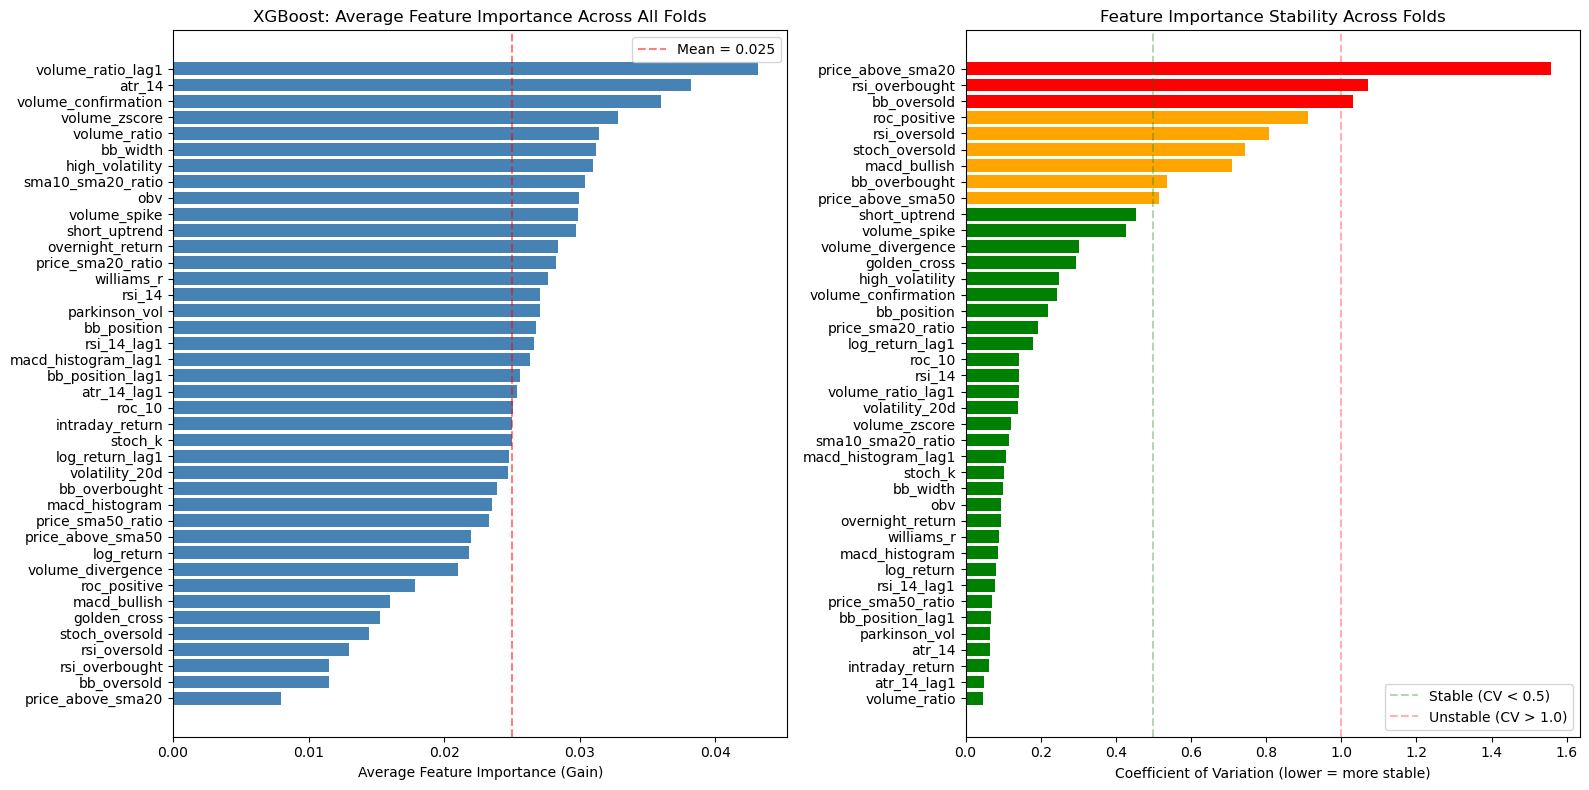

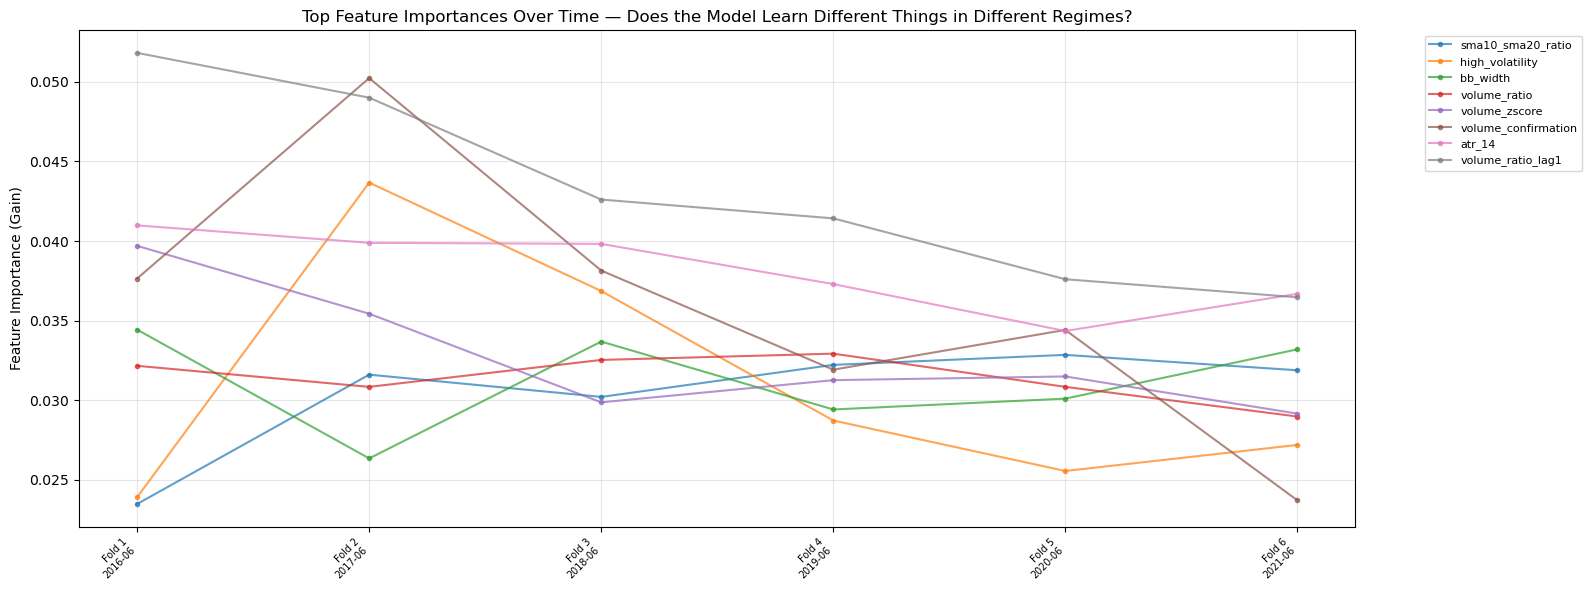

FEATURE IMPORTANCE SUMMARY

Total folds analyzed: 6

Top 5 most important features (avg across folds):
  volume_ratio              importance=0.0314  stability(CV)=0.05
  volume_zscore             importance=0.0328  stability(CV)=0.12
  volume_confirmation       importance=0.0360  stability(CV)=0.24
  atr_14                    importance=0.0382  stability(CV)=0.07
  volume_ratio_lag1         importance=0.0432  stability(CV)=0.14

Top 5 most STABLE features (low CV = consistent importance):
  volume_ratio              CV=0.05  importance=0.0314
  atr_14_lag1               CV=0.05  importance=0.0253
  intraday_return           CV=0.06  importance=0.0250
  atr_14                    CV=0.07  importance=0.0382
  parkinson_vol             CV=0.07  importance=0.0270

💡 KEY INSIGHT:
   Most important feature: 'volume_ratio_lag1' (avg importance: 0.0432)
   Most unstable feature:  'price_above_sma20' (CV: 1.56)
   → High CV means XGBoost relies on different features in different market regimes


In [852]:
# ═══════════════════════════════════════════════════════════════════════════════
# FEATURE IMPORTANCE ANALYSIS: What did XGBoost actually learn?
# ═══════════════════════════════════════════════════════════════════════════════

import matplotlib.gridspec as gridspec

# --- 1. Average Feature Importance Across All Folds ---
imp_df = pd.DataFrame(xgb_model.fold_importances)
avg_imp = imp_df.mean().sort_values(ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Bar chart of average importances
axes[0].barh(avg_imp.index, avg_imp.values, color='steelblue')
axes[0].set_xlabel('Average Feature Importance (Gain)')
axes[0].set_title('XGBoost: Average Feature Importance Across All Folds')
axes[0].axvline(x=avg_imp.mean(), color='red', linestyle='--', alpha=0.5, label=f'Mean = {avg_imp.mean():.3f}')
axes[0].legend()

# --- 2. Feature Importance Stability (how consistent is each feature?) ---
imp_std = imp_df.std()
imp_cv = (imp_std / imp_df.mean()).sort_values(ascending=True)  # Coefficient of variation
imp_cv = imp_cv.replace([np.inf, -np.inf], np.nan).dropna()

colors = ['green' if cv < 0.5 else 'orange' if cv < 1.0 else 'red' for cv in imp_cv.values]
axes[1].barh(imp_cv.index, imp_cv.values, color=colors)
axes[1].set_xlabel('Coefficient of Variation (lower = more stable)')
axes[1].set_title('Feature Importance Stability Across Folds')
axes[1].axvline(x=0.5, color='green', linestyle='--', alpha=0.3, label='Stable (CV < 0.5)')
axes[1].axvline(x=1.0, color='red', linestyle='--', alpha=0.3, label='Unstable (CV > 1.0)')
axes[1].legend()

plt.tight_layout()
plt.show()

# --- 3. Feature Importance Evolution Over Time ---
fig, ax = plt.subplots(figsize=(16, 6))
top_features = avg_imp.tail(8).index.tolist()  # Top 8 features

fold_labels = [f"Fold {m['fold']}\n{m['test_start'].strftime('%Y-%m')}" for m in xgb_model.fold_metadata]
for feat in top_features:
    if feat in imp_df.columns:
        ax.plot(range(len(imp_df)), imp_df[feat], marker='o', markersize=3, label=feat, alpha=0.7)

ax.set_xticks(range(len(fold_labels)))
ax.set_xticklabels(fold_labels, rotation=45, ha='right', fontsize=7)
ax.set_ylabel('Feature Importance (Gain)')
ax.set_title('Top Feature Importances Over Time — Does the Model Learn Different Things in Different Regimes?')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --- 4. Summary Statistics ---
print("=" * 80)
print("FEATURE IMPORTANCE SUMMARY")
print("=" * 80)

print(f"\nTotal folds analyzed: {len(xgb_model.fold_importances)}")
print(f"\nTop 5 most important features (avg across folds):")
for feat, imp in avg_imp.tail(5).items():
    stability = imp_cv.get(feat, np.nan)
    print(f"  {feat:<25} importance={imp:.4f}  stability(CV)={stability:.2f}")

print(f"\nTop 5 most STABLE features (low CV = consistent importance):")
for feat, cv in imp_cv.head(5).items():
    importance = avg_imp.get(feat, 0)
    print(f"  {feat:<25} CV={cv:.2f}  importance={importance:.4f}")

# Key insight
most_important = avg_imp.tail(1).index[0]
least_stable = imp_cv.tail(1).index[0]
print(f"\n💡 KEY INSIGHT:")
print(f"   Most important feature: '{most_important}' (avg importance: {avg_imp[most_important]:.4f})")
print(f"   Most unstable feature:  '{least_stable}' (CV: {imp_cv[least_stable]:.2f})")
print(f"   → High CV means XGBoost relies on different features in different market regimes")
print(f"   → This is evidence of REGIME SENSITIVITY in the ML model")

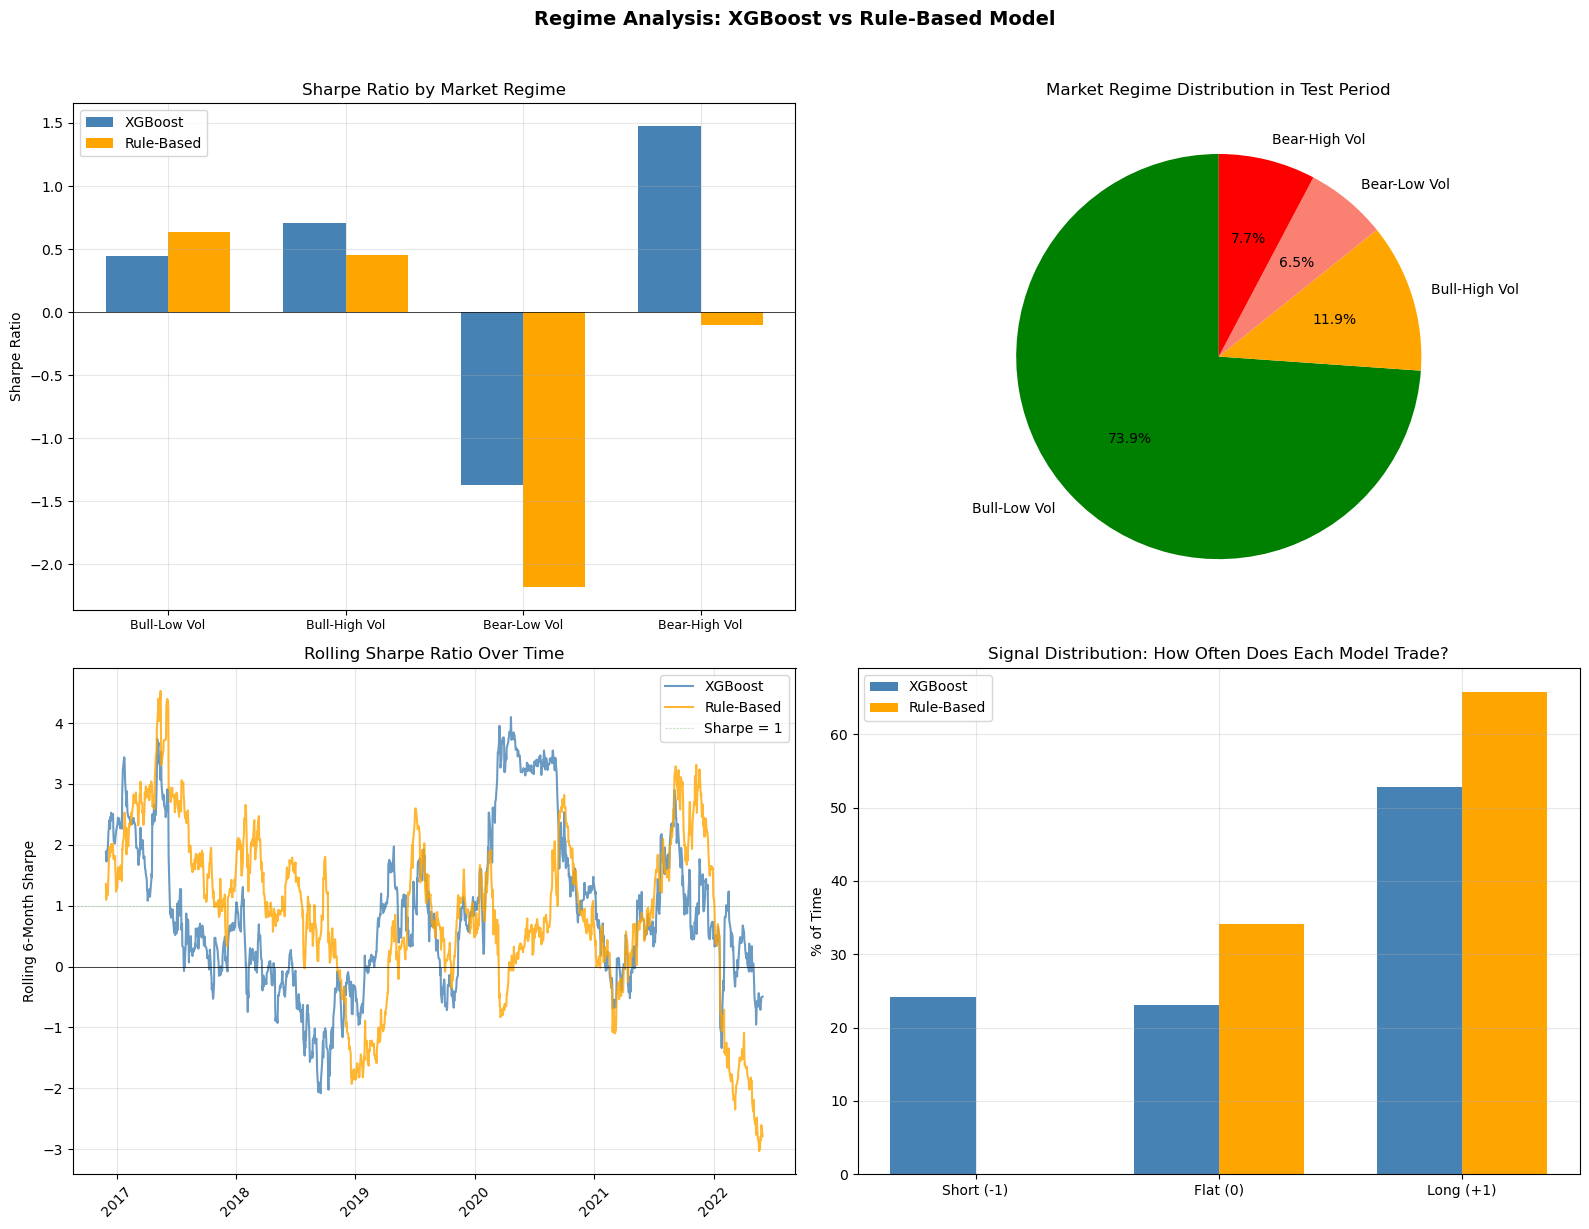

REGIME ANALYSIS SUMMARY

Regime                   Days   XGB Sharpe    RB Sharpe       Winner
----------------------------------------------------------------
  Bull-Low Vol           5790        0.443        0.637   Rule-Based
  Bull-High Vol           930        0.707        0.450      XGBoost
  Bear-Low Vol            510       -1.369       -2.177      XGBoost
  Bear-High Vol           606        1.473       -0.101      XGBoost

💡 XGBoost wins in 3/4 regimes
   Rule-Based wins in 1/4 regimes

   XGBoost's best regime: Bear-High Vol (advantage: +1.574)
   XGBoost's worst regime: Bull-Low Vol (disadvantage: -0.194)


In [ ]:

spy_data = xgb_test_data.xs('SPY', level='ticker').copy()
spy_data['sma50'] = spy_data['close'].rolling(50).mean()
spy_data['sma200'] = spy_data['close'].rolling(200).mean()
spy_data['rolling_vol'] = spy_data['log_return'].rolling(20).std() * np.sqrt(252)
spy_data['rolling_ret_60d'] = spy_data['log_return'].rolling(60).sum()

# Define regimes
def classify_regime(row):
    if pd.isna(row['sma200']) or pd.isna(row['rolling_vol']):
        return 'Unknown'
    if row['close'] > row['sma200'] and row['rolling_vol'] < 0.20:
        return 'Bull-Low Vol'
    elif row['close'] > row['sma200'] and row['rolling_vol'] >= 0.20:
        return 'Bull-High Vol'
    elif row['close'] <= row['sma200'] and row['rolling_vol'] < 0.25:
        return 'Bear-Low Vol'
    else:
        return 'Bear-High Vol'

spy_data['regime'] = spy_data.apply(classify_regime, axis=1)

# Map regime back to all tickers by date
regime_map = spy_data['regime']

# --- 2. Calculate per-regime performance ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare data for both models
xgb_with_regime = xgb_test_data.copy()
rb_with_regime = rb_model.data.copy()

# Add regime column by date
xgb_dates = xgb_with_regime.index.get_level_values('date')
rb_dates_idx = rb_with_regime.index.get_level_values('date')

xgb_with_regime['regime'] = xgb_dates.map(regime_map).values
rb_with_regime['regime'] = rb_dates_idx.map(regime_map).values

# Filter valid indices
valid_xgb = xgb_with_regime.dropna(subset=['strategy_return', 'regime'])
valid_rb = rb_with_regime.dropna(subset=['strategy_return', 'regime'])

regimes = ['Bull-Low Vol', 'Bull-High Vol', 'Bear-Low Vol', 'Bear-High Vol']
regime_colors = {'Bull-Low Vol': 'green', 'Bull-High Vol': 'orange', 'Bear-Low Vol': 'salmon', 'Bear-High Vol': 'red'}

# 2a. Sharpe ratio by regime
xgb_regime_sharpe = {}
rb_regime_sharpe = {}
regime_counts = {}

for regime in regimes:
    xgb_r = valid_xgb[valid_xgb['regime'] == regime]['strategy_return']
    rb_r = valid_rb[valid_rb['regime'] == regime]['strategy_return']
    
    if len(xgb_r) > 10:
        xgb_regime_sharpe[regime] = (xgb_r.mean() / xgb_r.std()) * np.sqrt(252) if xgb_r.std() > 0 else 0
    else:
        xgb_regime_sharpe[regime] = 0
    
    if len(rb_r) > 10:
        rb_regime_sharpe[regime] = (rb_r.mean() / rb_r.std()) * np.sqrt(252) if rb_r.std() > 0 else 0
    else:
        rb_regime_sharpe[regime] = 0
    
    regime_counts[regime] = len(xgb_r)

x_pos = np.arange(len(regimes))
width = 0.35
axes[0, 0].bar(x_pos - width/2, [xgb_regime_sharpe[r] for r in regimes], width, label='XGBoost', color='steelblue')
axes[0, 0].bar(x_pos + width/2, [rb_regime_sharpe[r] for r in regimes], width, label='Rule-Based', color='orange')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(regimes, fontsize=9)
axes[0, 0].set_ylabel('Sharpe Ratio')
axes[0, 0].set_title('Sharpe Ratio by Market Regime')
axes[0, 0].legend()
axes[0, 0].axhline(y=0, color='black', linewidth=0.5)
axes[0, 0].grid(True, alpha=0.3)

# 2b. Regime distribution (pie chart)
regime_pcts = {r: regime_counts.get(r, 0) for r in regimes}
colors_pie = [regime_colors[r] for r in regimes]
wedges, texts, autotexts = axes[0, 1].pie(
    regime_pcts.values(), labels=regime_pcts.keys(), autopct='%1.1f%%',
    colors=colors_pie, startangle=90
)
axes[0, 1].set_title('Market Regime Distribution in Test Period')

# 2c. Rolling 6-month Sharpe comparison
rolling_window = 126  # ~6 months
xgb_all_returns = valid_xgb.groupby(level='date')['strategy_return'].mean()
rb_all_returns = valid_rb.groupby(level='date')['strategy_return'].mean()

xgb_rolling_sharpe = (xgb_all_returns.rolling(rolling_window).mean() / 
                       xgb_all_returns.rolling(rolling_window).std()) * np.sqrt(252)
rb_rolling_sharpe = (rb_all_returns.rolling(rolling_window).mean() / 
                      rb_all_returns.rolling(rolling_window).std()) * np.sqrt(252)

axes[1, 0].plot(xgb_rolling_sharpe.index, xgb_rolling_sharpe.values, label='XGBoost', color='steelblue', alpha=0.8)
axes[1, 0].plot(rb_rolling_sharpe.index, rb_rolling_sharpe.values, label='Rule-Based', color='orange', alpha=0.8)
axes[1, 0].axhline(y=0, color='black', linewidth=0.5)
axes[1, 0].axhline(y=1, color='green', linewidth=0.5, linestyle='--', alpha=0.3, label='Sharpe = 1')
axes[1, 0].set_ylabel('Rolling 6-Month Sharpe')
axes[1, 0].set_title('Rolling Sharpe Ratio Over Time')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# 2d. Signal distribution comparison
xgb_signals = valid_xgb['signal'].value_counts().sort_index()
rb_signals = valid_rb['signal'].value_counts().sort_index()

signal_labels = ['Short (-1)', 'Flat (0)', 'Long (+1)']
xgb_signal_pcts = [(xgb_signals.get(s, 0) / len(valid_xgb)) * 100 for s in [-1, 0, 1]]
rb_signal_pcts = [(rb_signals.get(s, 0) / len(valid_rb)) * 100 for s in [-1, 0, 1]]

x_sig = np.arange(len(signal_labels))
axes[1, 1].bar(x_sig - width/2, xgb_signal_pcts, width, label='XGBoost', color='steelblue')
axes[1, 1].bar(x_sig + width/2, rb_signal_pcts, width, label='Rule-Based', color='orange')
axes[1, 1].set_xticks(x_sig)
axes[1, 1].set_xticklabels(signal_labels)
axes[1, 1].set_ylabel('% of Time')
axes[1, 1].set_title('Signal Distribution: How Often Does Each Model Trade?')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Regime Analysis: XGBoost vs Rule-Based Model', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --- 3. Print Regime Summary ---
print("=" * 80)
print("REGIME ANALYSIS SUMMARY")
print("=" * 80)

print(f"\n{'Regime':<20} {'Days':>8} {'XGB Sharpe':>12} {'RB Sharpe':>12} {'Winner':>12}")
print("-" * 64)
for regime in regimes:
    xgb_s = xgb_regime_sharpe[regime]
    rb_s = rb_regime_sharpe[regime]
    winner = "XGBoost" if xgb_s > rb_s else "Rule-Based"
    count = regime_counts.get(regime, 0)
    print(f"  {regime:<18} {count:>8} {xgb_s:>12.3f} {rb_s:>12.3f} {winner:>12}")

xgb_wins = sum(1 for r in regimes if xgb_regime_sharpe[r] > rb_regime_sharpe[r])
print(f"\n💡 XGBoost wins in {xgb_wins}/{len(regimes)} regimes")
print(f"   Rule-Based wins in {len(regimes)-xgb_wins}/{len(regimes)} regimes")

# Key insight
best_xgb_regime = max(regimes, key=lambda r: xgb_regime_sharpe[r] - rb_regime_sharpe[r])
worst_xgb_regime = min(regimes, key=lambda r: xgb_regime_sharpe[r] - rb_regime_sharpe[r])
print(f"\n   XGBoost's best regime: {best_xgb_regime} (advantage: {xgb_regime_sharpe[best_xgb_regime]-rb_regime_sharpe[best_xgb_regime]:+.3f})")
print(f"   XGBoost's worst regime: {worst_xgb_regime} (disadvantage: {xgb_regime_sharpe[worst_xgb_regime]-rb_regime_sharpe[worst_xgb_regime]:+.3f})")

Done


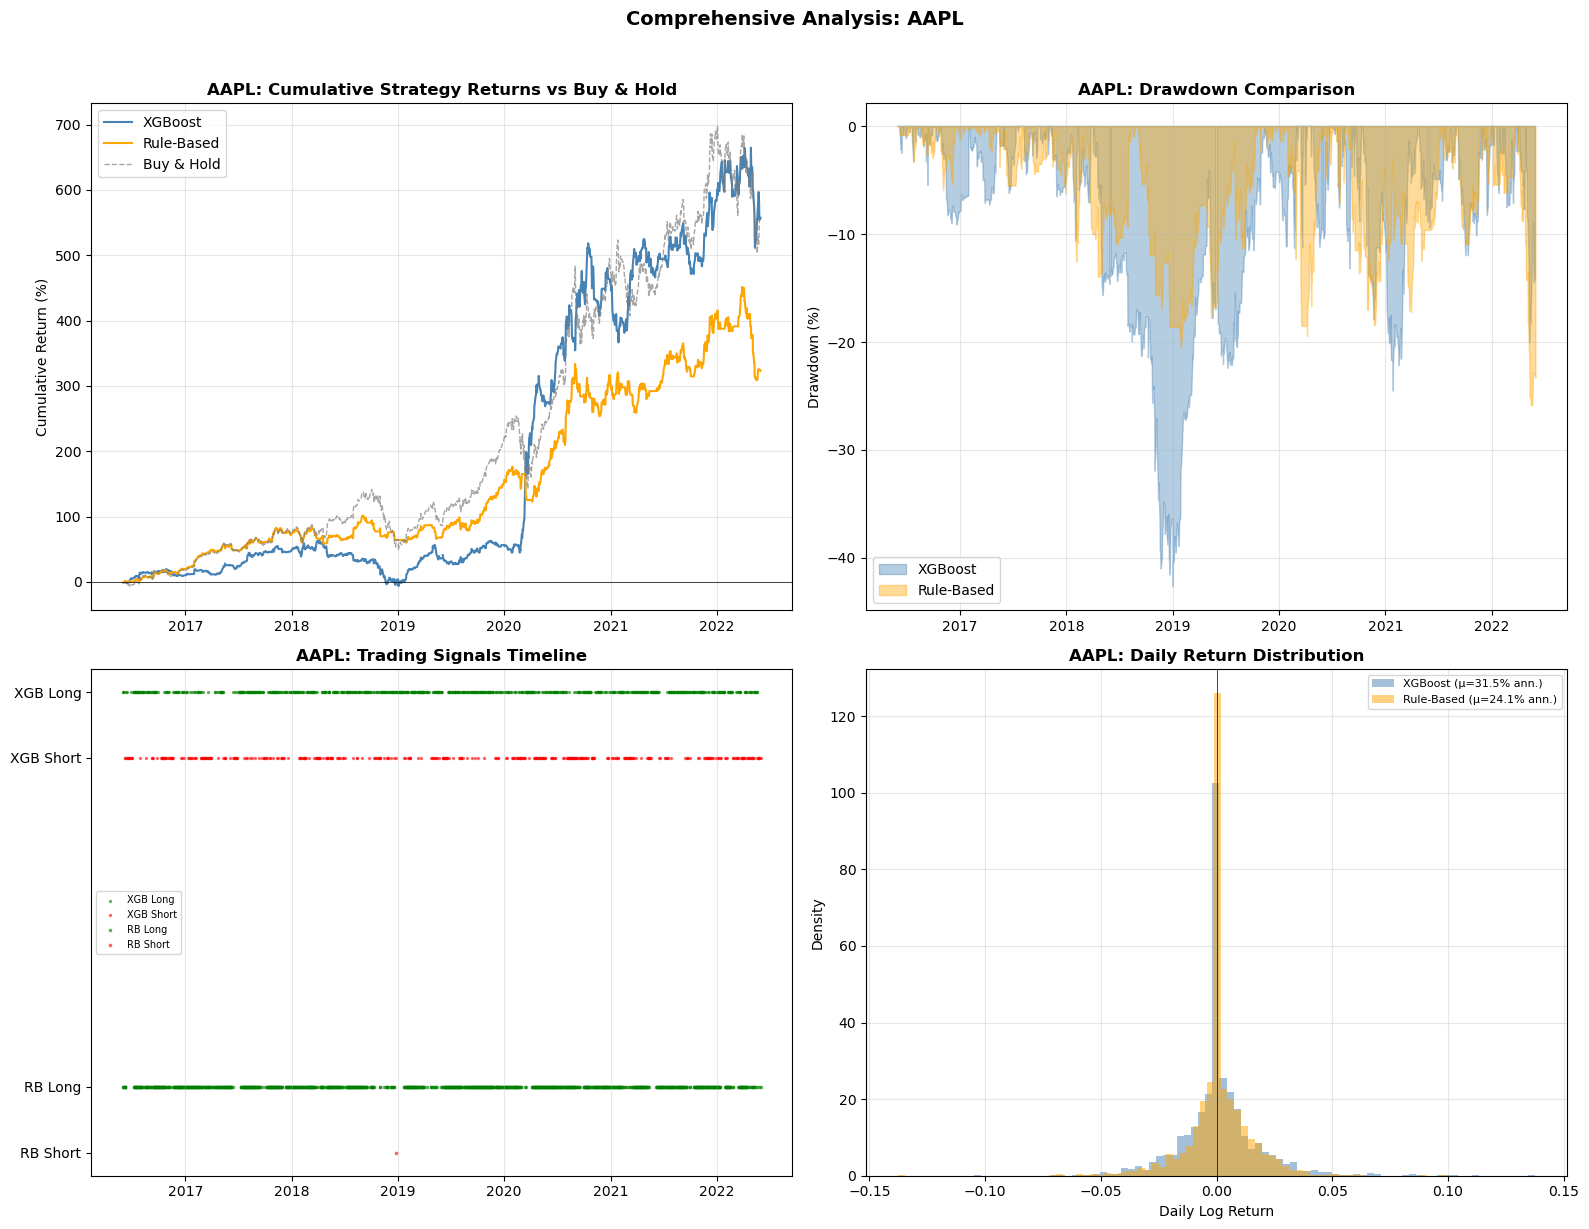

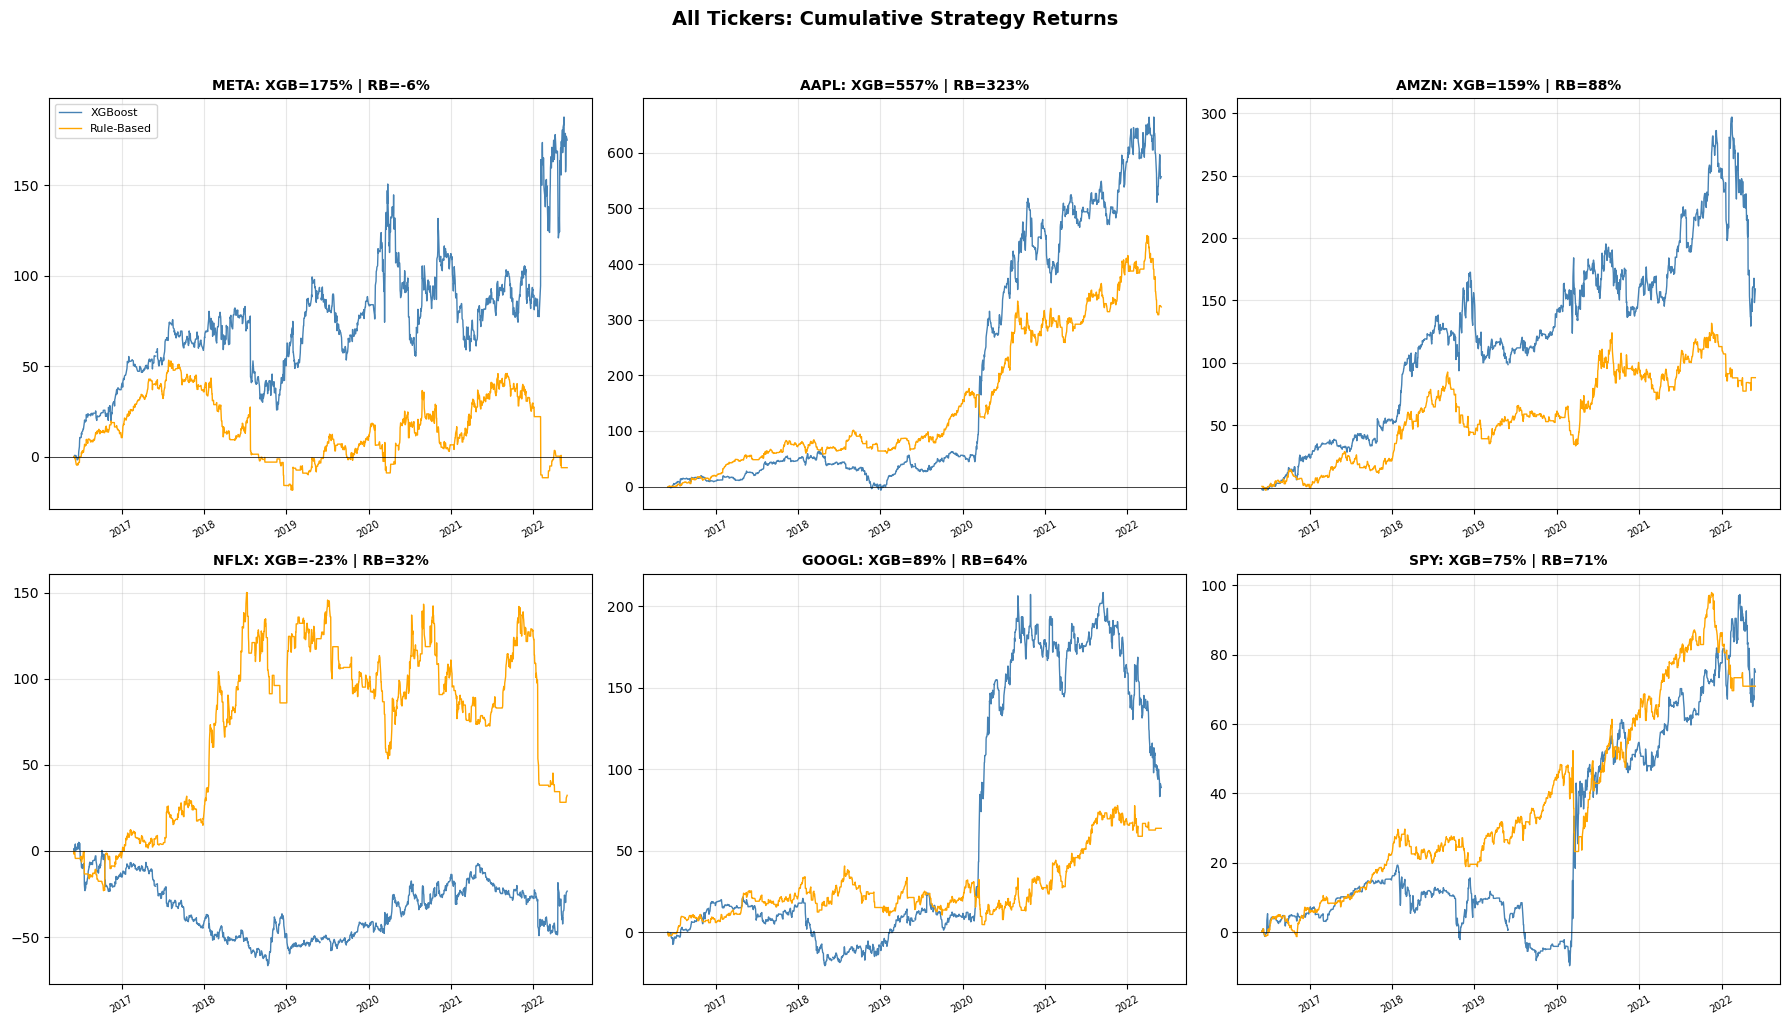

In [854]:

tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL', 'SPY']
continued_input = True
while continued_input == True:
    input_ticker = input("Please enter a stock ('AAPL') for example: " )
    for i in range(6):
        if input_ticker == tickers[i]:
            print("Done")
            continued_input = False

# --- Prepare data for selected ticker ---
graphed_df = rb_model.data.xs(input_ticker, level=0)
strategy_graphed_return_pct = (np.exp(graphed_df['strategy_return'].cumsum()) - 1) * 100
dates = graphed_df.index

xgb_graphed_cum_return_pct = (
    xgb_test_data
    .groupby(level='ticker')['strategy_return']
    .apply(lambda x: (np.exp(x.cumsum()) - 1) * 100)
)
xgb_graphed_returns = xgb_graphed_cum_return_pct.xs(input_ticker, level=0)

# Buy & hold for comparison
bh_return_pct = (np.exp(graphed_df['log_return'].cumsum()) - 1) * 100
# --- Figure 1: Cumulative Returns with Buy & Hold ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1a. Cumulative returns comparison (with buy & hold)
axes[0, 0].plot(dates, xgb_graphed_returns, label='XGBoost', color='steelblue', linewidth=1.5)
axes[0, 0].plot(dates[:len(strategy_graphed_return_pct)], strategy_graphed_return_pct, 
                label='Rule-Based', color='orange', linewidth=1.5)
axes[0, 0].plot(dates[:len(bh_return_pct)], bh_return_pct, 
                label='Buy & Hold', color='gray', linewidth=1, linestyle='--', alpha=0.7)
axes[0, 0].set_title(f'{input_ticker}: Cumulative Strategy Returns vs Buy & Hold', fontweight='bold')
axes[0, 0].set_ylabel('Cumulative Return (%)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0, color='black', linewidth=0.5)

# 1b. Drawdown comparison
xgb_ticker = xgb_test_data.xs(input_ticker, level='ticker')
xgb_cum = xgb_ticker['strategy_return'].cumsum()
xgb_dd = (xgb_cum - xgb_cum.expanding().max())
xgb_dd_pct = (np.exp(xgb_dd) - 1) * 100

rb_cum = graphed_df['strategy_return'].cumsum()
rb_dd = (rb_cum - rb_cum.expanding().max())
rb_dd_pct = (np.exp(rb_dd) - 1) * 100

axes[0, 1].fill_between(xgb_ticker.index, xgb_dd_pct, 0, alpha=0.4, color='steelblue', label='XGBoost')
axes[0, 1].fill_between(dates[:len(rb_dd_pct)], rb_dd_pct, 0, alpha=0.4, color='orange', label='Rule-Based')
axes[0, 1].set_title(f'{input_ticker}: Drawdown Comparison', fontweight='bold')
axes[0, 1].set_ylabel('Drawdown (%)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 1c. Signal distribution over time
xgb_signals_ticker = xgb_ticker['signal']
rb_signals_ticker = graphed_df['signal']

axes[1, 0].scatter(xgb_ticker.index[xgb_signals_ticker == 1], 
                   [1.1] * (xgb_signals_ticker == 1).sum(), 
                   color='green', s=2, alpha=0.5, label='XGB Long')
axes[1, 0].scatter(xgb_ticker.index[xgb_signals_ticker == -1], 
                   [0.9] * (xgb_signals_ticker == -1).sum(), 
                   color='red', s=2, alpha=0.5, label='XGB Short')
axes[1, 0].scatter(dates[rb_signals_ticker == 1], 
                   [-0.1] * (rb_signals_ticker == 1).sum(), 
                   color='green', s=2, alpha=0.5, marker='s', label='RB Long')
axes[1, 0].scatter(dates[rb_signals_ticker == -1], 
                   [-0.3] * (rb_signals_ticker == -1).sum(), 
                   color='red', s=2, alpha=0.5, marker='s', label='RB Short')
axes[1, 0].set_yticks([1.1, 0.9, -0.1, -0.3])
axes[1, 0].set_yticklabels(['XGB Long', 'XGB Short', 'RB Long', 'RB Short'])
axes[1, 0].set_title(f'{input_ticker}: Trading Signals Timeline', fontweight='bold')
axes[1, 0].legend(loc='center left', fontsize=7)
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 1d. Daily returns distribution
xgb_daily = xgb_ticker['strategy_return'].dropna()
rb_daily = graphed_df['strategy_return'].dropna()

axes[1, 1].hist(xgb_daily, bins=80, alpha=0.5, color='steelblue', label=f'XGBoost (μ={xgb_daily.mean()*252*100:.1f}% ann.)', density=True)
axes[1, 1].hist(rb_daily, bins=80, alpha=0.5, color='orange', label=f'Rule-Based (μ={rb_daily.mean()*252*100:.1f}% ann.)', density=True)
axes[1, 1].axvline(x=0, color='black', linewidth=0.5)
axes[1, 1].set_title(f'{input_ticker}: Daily Return Distribution', fontweight='bold')
axes[1, 1].set_xlabel('Daily Log Return')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend(fontsize=8)
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'Comprehensive Analysis: {input_ticker}', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# --- Figure 2: Multi-Ticker Overview ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, t in enumerate(tickers):
    # Get data for each ticker
    t_xgb = xgb_test_data.xs(t, level='ticker')['strategy_return']
    t_rb = rb_model.data.xs(t, level='ticker')['strategy_return']
    
    t_xgb_cum = (np.exp(t_xgb.cumsum()) - 1) * 100
    t_rb_cum = (np.exp(t_rb.cumsum()) - 1) * 100
    
    axes[idx].plot(t_xgb_cum.index, t_xgb_cum.values, color='steelblue', linewidth=1, label='XGBoost')
    axes[idx].plot(t_rb_cum.index, t_rb_cum.values, color='orange', linewidth=1, label='Rule-Based')
    axes[idx].axhline(y=0, color='black', linewidth=0.5)
    
    # Add final return annotation
    xgb_final = t_xgb_cum.iloc[-1] if len(t_xgb_cum) > 0 else 0
    rb_final = t_rb_cum.iloc[-1] if len(t_rb_cum) > 0 else 0
    axes[idx].set_title(f'{t}: XGB={xgb_final:.0f}% | RB={rb_final:.0f}%', fontweight='bold', fontsize=10)
    axes[idx].tick_params(axis='x', rotation=30, labelsize=7)
    axes[idx].grid(True, alpha=0.3)
    if idx == 0:
        axes[idx].legend(fontsize=8)

plt.suptitle('All Tickers: Cumulative Strategy Returns', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()